# DS-SF-36 | Final Project 2 | Predicting QBDT customers migrating to QBES in the next 12 months

## Problem Statement: Predict QuickBooks Desktop (QBDT) customers who are likely to migrate to QuickBooks Enterprise Solutions (QBES) in the next 12 months.  

    - Intuit SBG can better market to these customers with the appropriate message and offers.
    - Better personalization to the customers.
    - Prediction is a binary variable of 1 = Yes, migrated to QBES, and 0 = No, did not migrate to QBES.
    - Variables that are likely predictive of QBES conversion are company revenue, company employee counts, QBDT version year, customer's total revenue to Intuit, QBDT product type, QBDT purchase channel, etc.
    - Logistic regression(s) were typically used, but with this projects, I would like to explore other ML methods such as Random Forests & Boosted Trees.
    

## Dataset: Various datasets were preprocessed and combined to make the final dataset, which included the following categories:

    - QBDT product data (version year, product SKU, etc)
    - Dun & Bradstreet firmographic data (company size, employee count, etc)
    - QBDT Payments data (charge volume in the last 3 months, number of transactions in 1 month, etc)
    - Customer 360 degree view (customer’s other product relationship with Intuit SBG)
    - Supplies data (customer’s checks, tax form order transaction history)
    - Email engagement data (how recently a customer opened an email, how many times did customer clicked on links, etc)
    - NPS score & Sentiments (how do customers feel about using QBDT, positive/neutral/negative)
    - QBDT payroll data (how much did customer pay their employees in the past)

### With the exception of the Dun & Bradstreet data (2nd bullet above), all other date are collected internally.
### QBDT customers migrate to QBES at a very low rate of 0.15% in 12 months.  The modeling dataset is oversampled to 5%, and a 30% validation sample is separated out for testing purpose.


## Domain Knowledge:

    - A version of this project is currently run under SAS with logistic regression.  The model is refreshed annually before the annual QBDT launch in September.
    - I am very familiar with this data as I am the main contributor to the current logistic regression model.
    - I have many years of analytics and predictive modeling experience and believe those skillset will help me transition this model from SAS (logistic regression) to Python (other modelings techniques).
    - The models built with Python will be benchmarked against the current SAS logistic regression model.  This enables us to better integrate the model with the production system.
    

## Project Concerns:

    - Will the Random Forests and Boosted tree provide better prediction accuracy?  The current logist regression already captures 84% of the QBES conversion in the top 4 deciles.
    - Will I be able to explain the model to stakeholders as easily as a logistic regression?
    - Data is fairly messy across many different databases and data sources, with "fuzzy" ID matching logic.
    - Our hope is to be able to increase the prediction accuracy and targeting fewer deciles, while still able to capture 80%+ of the QBES conversions.  The cost of an inaccurate model would leads to millions of revenue lost to Intuit in sales, as well as a lot of manhours lost due to targeting customers who show low propensity.
    - Data is sparse across most of the fields.  However, this seems to be quite typical.

## Output of the project: 

    - The output of the project will be a detailed deck explaining the following:
        * Model methodology: what criteria did I use to determine my final model?
        * Final variables: do they make logical and business sense?
        * Simple model metrics: lift chart, score cutoff recommendations & trade-offs
    - The project is considered successfull if it can predict QBDT->QBES migrations more accurately than the current logistic regression.  

In [181]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,auc,confusion_matrix, precision_score, recall_score
from sklearn.externals import joblib



# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# from sklearn import preprocessing, linear_model, model_selection, metrics

# from sklearn.cross_validation import train_test_split, cross_val_score
# from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
# from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'ES-active-model.csv'))
df.head()

,cust_id,POE_Product,POE_version,POE_channel,PREV_Product,...,EM_hist_flag,prs_flag,payroll_hist_flag,mrv_version_active,mod_val_test
0,159735070,Pro,1997,Mail,Premier,...,0,1,0,Yes,1
1,160105729,Basic,1995,RETAIL,Mac,...,0,0,1,Yes,1
2,163228621,Pro,1999,Web,Pro,...,0,1,0,Yes,1
3,266595274,Basic,1997,Telesales and Emerging,Pro,...,1,0,1,Yes,2
4,276426190,Pro,1997,RETAIL,Pro,...,0,0,0,Yes,2


In [3]:
df.shape

(34340, 185)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34340 entries, 0 to 34339
Columns: 185 entries, cust_id to mod_val_test
dtypes: float64(149), int64(19), object(17)
memory usage: 48.5+ MB


## es_resp is the outcome variable.  It has been over sampled to 5% like previously mentioned.

In [5]:
df.es_resp.value_counts(normalize=True)

0    0.95
1    0.05
Name: es_resp, dtype: float64

## datasets have a lot of fields with high missing count.  But sometimes these missing indicators are very useful.

In [6]:
df.isnull().sum()

cust_id                    0
POE_Product                0
POE_version                0
POE_channel                0
PREV_Product           13458
PREV_version           13458
PREV_channel           13458
MRV_Product                0
MRV_version                0
MRV_channel                0
                       ...  
payroll_last_avgamt    33058
es_resp                    0
payments_hist_flag         0
hv_flag                    0
supplies_hist_flag         0
EM_hist_flag               0
prs_flag                   0
payroll_hist_flag          0
mrv_version_active         0
mod_val_test               0
Length: 185, dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cust_id,34340.0,8.146384e+08,4.179990e+08,50628844.00,4.745155e+08,8.115184e+08,1.193254e+09,1.596633e+09
POE_version,34340.0,2.008546e+03,6.666060e+00,1993.00,2.003000e+03,2.011000e+03,2.014000e+03,2.016000e+03
PREV_version,20882.0,2.011075e+03,2.764939e+00,1994.00,2.010000e+03,2.012000e+03,2.013000e+03,2.016000e+03
MRV_version,34340.0,2.014897e+03,8.176720e-01,2014.00,2.014000e+03,2.015000e+03,2.016000e+03,2.016000e+03
MRV_agg_seats,34340.0,1.000000e+00,0.000000e+00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
PAYMENT_FLAG,34340.0,5.349447e-02,2.250206e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
PAYROLL_FLAG,34340.0,2.624636e-01,4.399797e-01,0.00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
num_yr_first_QB,34340.0,7.453873e+00,6.666060e+00,0.00,2.000000e+00,5.000000e+00,1.300000e+01,2.300000e+01
num_yr_last_QB,34340.0,1.103291e+00,8.176720e-01,0.00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
num_yr_last_upgrade,20882.0,3.889426e+00,2.630964e+00,0.00,3.000000e+00,3.000000e+00,4.000000e+00,2.000000e+01


## number of payment accounts each customers have

In [8]:
df.PA110.value_counts()

1.0     2523
2.0      725
3.0      236
4.0       92
5.0       32
6.0       19
7.0        8
8.0        7
10.0       2
13.0       1
Name: PA110, dtype: int64

## number of years since the first supplies purchase

In [9]:
df.SU101.value_counts()

4.0    1771
5.0    1659
3.0     757
2.0     585
1.0     409
0.0     150
Name: SU101, dtype: int64

## number of years since last upgrade

In [10]:
df.num_yr_last_upgrade.value_counts()

3.0     9502
2.0     2585
4.0     1771
1.0     1637
5.0     1343
6.0     1223
7.0      743
8.0      505
9.0      406
0.0      226
        ... 
11.0     184
12.0     134
13.0      93
15.0      91
14.0      83
16.0      52
17.0      43
18.0      25
20.0       7
19.0       7
Name: num_yr_last_upgrade, Length: 21, dtype: int64

## EDA analysis for top categorical variables

EDA Analysis for variable: EM_hist_flag


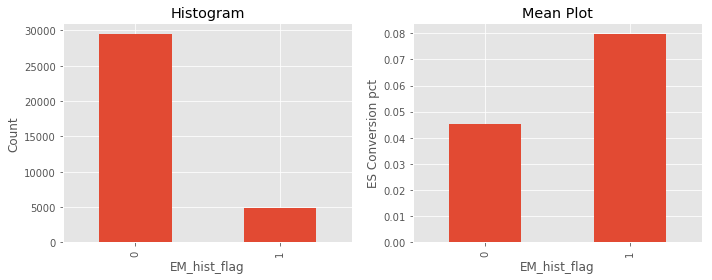

EM_hist_flag         0         1
es_resp                         
0             0.954853  0.920233
1             0.045147  0.079767
                                                          
                                                          
EDA Analysis for variable: MRV_Product


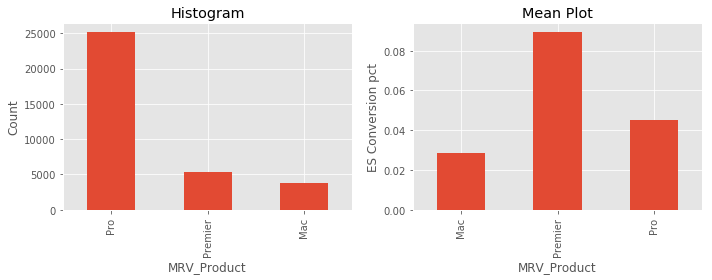

MRV_Product       Mac   Premier       Pro
es_resp                                  
0            0.971495  0.910724  0.955048
1            0.028505  0.089276  0.044952
                                                          
                                                          
EDA Analysis for variable: PAYMENT_FLAG


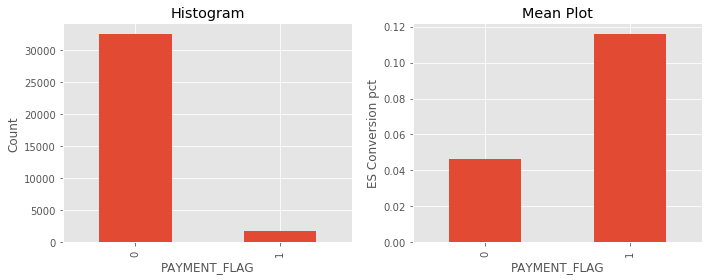

PAYMENT_FLAG         0        1
es_resp                        
0             0.953727  0.88405
1             0.046273  0.11595
                                                          
                                                          
EDA Analysis for variable: PAYROLL_FLAG


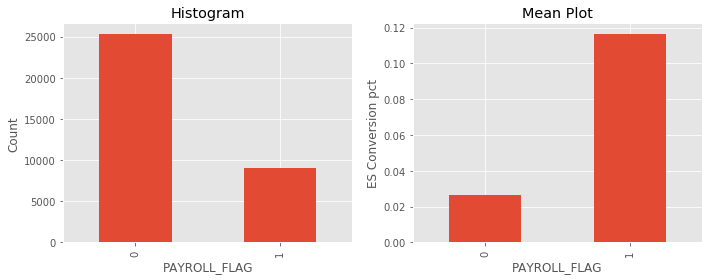

PAYROLL_FLAG         0         1
es_resp                         
0             0.973664  0.883502
1             0.026336  0.116498
                                                          
                                                          
EDA Analysis for variable: POE_Product


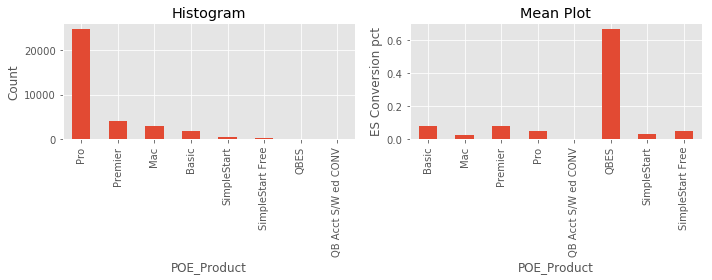

POE_Product     Basic       Mac   Premier       Pro  QB Acct S/W ed CONV  \
es_resp                                                                    
0            0.922735  0.979181  0.919136  0.953613                  1.0   
1            0.077265  0.020819  0.080864  0.046387                  0.0   

POE_Product      QBES  SimpleStart  SimpleStart Free  
es_resp                                               
0            0.333333     0.971491          0.951923  
1            0.666667     0.028509          0.048077  
                                                          
                                                          
EDA Analysis for variable: PREV_Product


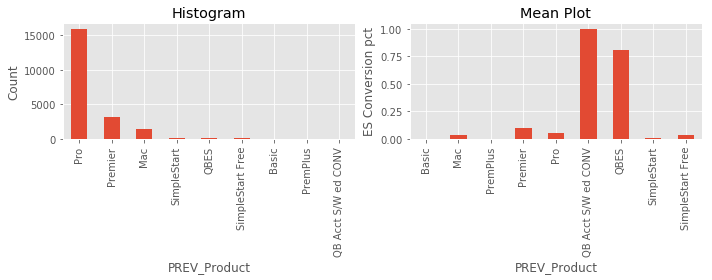

PREV_Product  Basic       Mac  PremPlus   Premier       Pro  \
es_resp                                                       
0               1.0  0.960898       1.0  0.897625  0.950057   
1               0.0  0.039102       0.0  0.102375  0.049943   

PREV_Product  QB Acct S/W ed CONV      QBES  SimpleStart  SimpleStart Free  
es_resp                                                                     
0                             0.0  0.190184     0.989529          0.960784  
1                             1.0  0.809816     0.010471          0.039216  
                                                          
                                                          
EDA Analysis for variable: PREV_channel


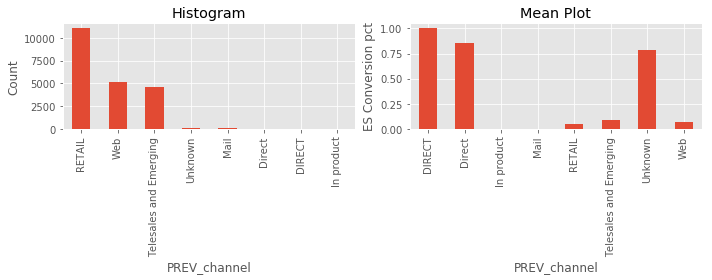

PREV_channel  DIRECT    Direct  In product  Mail   RETAIL  \
es_resp                                                     
0                0.0  0.142857         1.0   1.0  0.95462   
1                1.0  0.857143         0.0   0.0  0.04538   

PREV_channel  Telesales and Emerging   Unknown      Web  
es_resp                                                  
0                           0.912404  0.211268  0.93403  
1                           0.087596  0.788732  0.06597  
                                                          
                                                          
EDA Analysis for variable: PREV_version


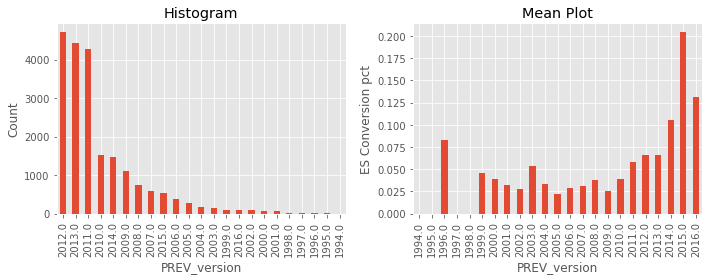

PREV_version  1994.0  1995.0    1996.0  1997.0  1998.0    ...       2012.0  \
es_resp                                                   ...                
0                1.0     1.0  0.916667     1.0     1.0    ...     0.934085   
1                0.0     0.0  0.083333     0.0     0.0    ...     0.065915   

PREV_version    2013.0    2014.0   2015.0    2016.0  
es_resp                                              
0             0.933785  0.895024  0.79619  0.869159  
1             0.066215  0.104976  0.20381  0.130841  

[2 rows x 23 columns]
                                                          
                                                          
EDA Analysis for variable: SM_AttachOffering


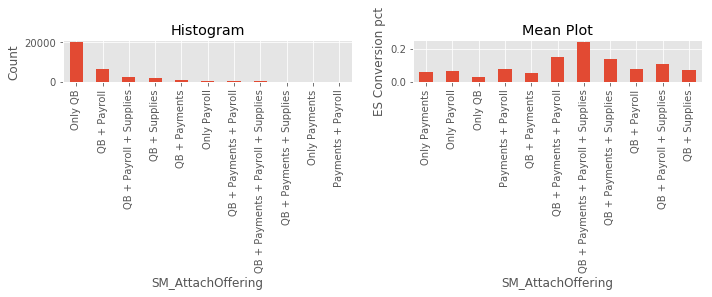

SM_AttachOffering  Only Payments  Only Payroll   Only QB  Payments + Payroll  \
es_resp                                                                        
0                         0.9375      0.934043  0.971909            0.923077   
1                         0.0625      0.065957  0.028091            0.076923   

SM_AttachOffering  QB + Payments      ...        \
es_resp                               ...         
0                       0.944578      ...         
1                       0.055422      ...         

SM_AttachOffering  QB + Payments + Payroll + Supplies  \
es_resp                                                 
0                                            0.761905   
1                                            0.238095   

SM_AttachOffering  QB + Payments + Supplies  QB + Payroll  \
es_resp                                                     
0                                  0.860606       0.92486   
1                                  0.139394       0.07514   



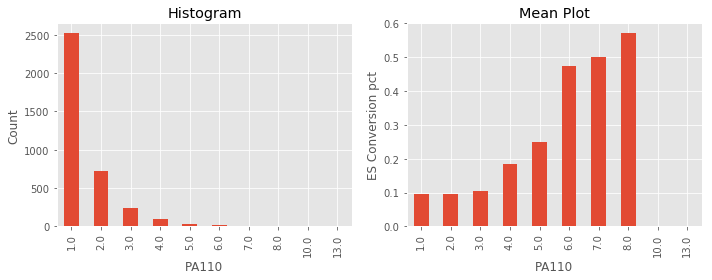

PA110        1.0       2.0       3.0       4.0   5.0       6.0   7.0   \
es_resp                                                                 
0        0.905272  0.903448  0.894068  0.815217  0.75  0.526316   0.5   
1        0.094728  0.096552  0.105932  0.184783  0.25  0.473684   0.5   

PA110        8.0   10.0  13.0  
es_resp                        
0        0.428571   1.0   1.0  
1        0.571429   0.0   0.0  
                                                          
                                                          
EDA Analysis for variable: SU101


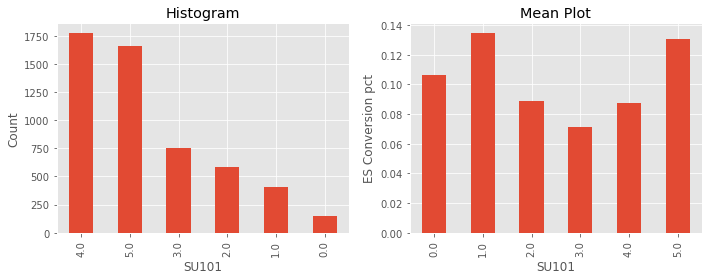

SU101         0.0       1.0       2.0       3.0       4.0       5.0
es_resp                                                            
0        0.893333  0.865526  0.911111  0.928666  0.912479  0.869198
1        0.106667  0.134474  0.088889  0.071334  0.087521  0.130802
                                                          
                                                          
EDA Analysis for variable: num_yr_last_upgrade


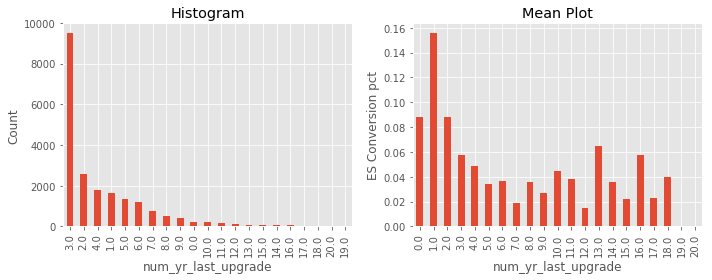

num_yr_last_upgrade      0.0       1.0       2.0       3.0      4.0   ...   \
es_resp                                                               ...    
0                    0.911504  0.844227  0.911799  0.942328  0.95144  ...    
1                    0.088496  0.155773  0.088201  0.057672  0.04856  ...    

num_yr_last_upgrade      16.0      17.0  18.0  19.0  20.0  
es_resp                                                    
0                    0.942308  0.976744  0.96   1.0   1.0  
1                    0.057692  0.023256  0.04   0.0   0.0  

[2 rows x 21 columns]
                                                          
                                                          
EDA Analysis for variable: eager_upgrader


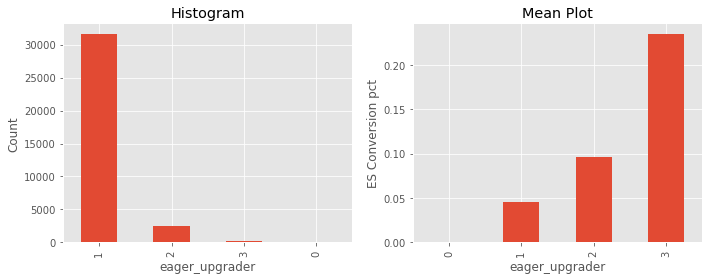

eager_upgrader    0         1         2         3
es_resp                                          
0               1.0  0.954831  0.904225  0.765258
1               0.0  0.045169  0.095775  0.234742
                                                          
                                                          
EDA Analysis for variable: industry


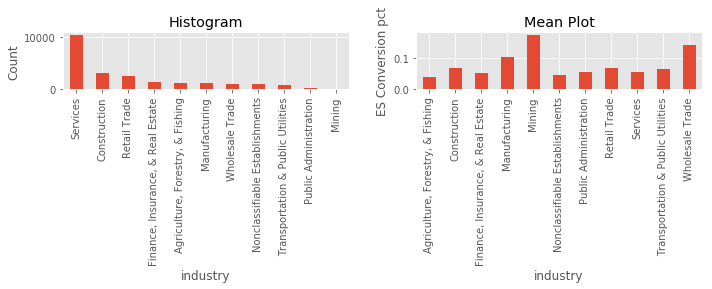

industry  Agriculture, Forestry, & Fishing  Construction  \
es_resp                                                    
0                                 0.959645      0.932945   
1                                 0.040355      0.067055   

industry  Finance, Insurance, & Real Estate  Manufacturing    Mining  \
es_resp                                                                
0                                  0.948242       0.896014  0.828125   
1                                  0.051758       0.103986  0.171875   

industry       ...         Public Administration  Retail Trade  Services  \
es_resp        ...                                                         
0              ...                       0.94359      0.933227  0.943349   
1              ...                       0.05641      0.066773  0.056651   

industry  Transportation & Public Utilities  Wholesale Trade  
es_resp                                                       
0                                  0.93

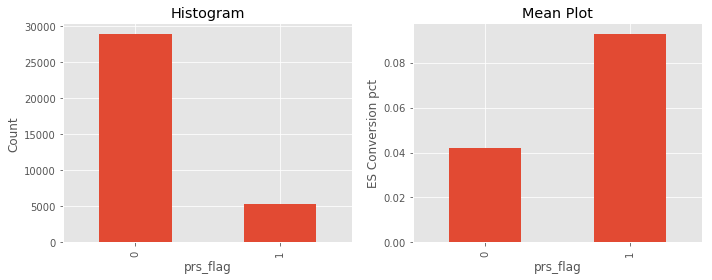

prs_flag         0         1
es_resp                     
0         0.957931  0.907159
1         0.042069  0.092841
                                                          
                                                          
EDA Analysis for variable: revenue_grp


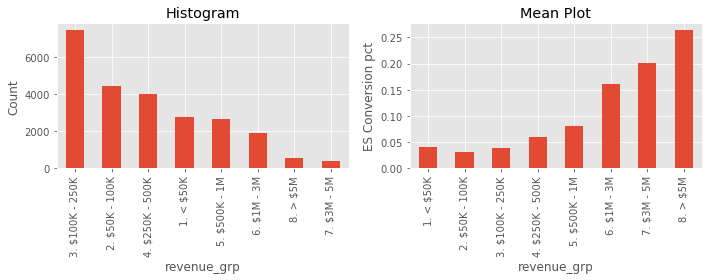

revenue_grp  1. < $50K  2. $50K - 100K  3. $100K - 250K  4. $250K - 500K  \
es_resp                                                                    
0             0.958243        0.969349         0.961172         0.939975   
1             0.041757        0.030651         0.038828         0.060025   

revenue_grp  5. $500K - 1M  6. $1M - 3M  7. $3M - 5M  8. > $5M  
es_resp                                                         
0                 0.919031     0.839032     0.798942  0.736449  
1                 0.080969     0.160968     0.201058  0.263551  
                                                          
                                                          
EDA Analysis for variable: supplies_hist_flag


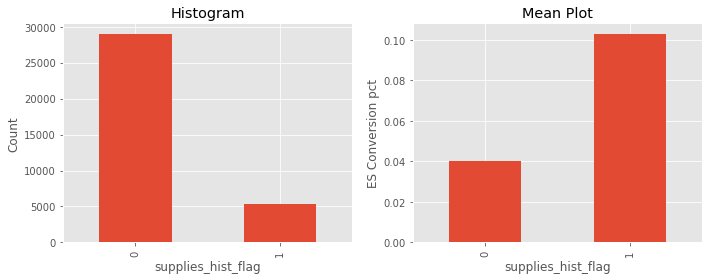

supplies_hist_flag         0         1
es_resp                               
0                   0.959737  0.897017
1                   0.040263  0.102983
                                                          
                                                          
EDA Analysis for variable: total_QB_cnt


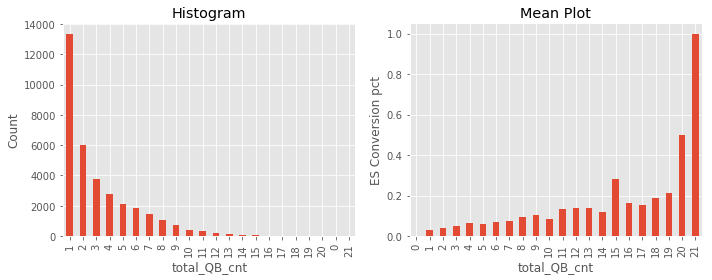

total_QB_cnt   0         1         2         3         4  ...         17  \
es_resp                                                   ...              
0             1.0  0.969779  0.958126  0.949707  0.936963 ...   0.846154   
1             0.0  0.030221  0.041874  0.050293  0.063037 ...   0.153846   

total_QB_cnt      18        19   20   21  
es_resp                                   
0             0.8125  0.785714  0.5  0.0  
1             0.1875  0.214286  0.5  1.0  

[2 rows x 22 columns]
                                                          
                                                          


In [11]:
def CAT_EDA_graph(variable):
    print('EDA Analysis for variable: {}'.format(variable))
    fig=plt.figure(figsize=(10,4))
    
    ax1=fig.add_subplot(121)
    df[variable].value_counts().plot(kind='bar')
    ax1.set_title('Histogram')
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Count')

    ax2=fig.add_subplot(122)
    ax2.set_xlabel(variable)
    ax2.set_ylabel('ES Conversion pct')
    df.groupby(df[variable]).es_resp.mean().plot.bar()
    ax2.set_title('Mean Plot')
    
    plt.tight_layout()
    plt.show()

    print(pd.crosstab(df.es_resp, df[variable],dropna=False,normalize='columns'))
    print('                                                          ')
    print('                                                          ')

lst=['EM_hist_flag',
'MRV_Product',
# 'PAYMENTS_CHARGEVOL',
'PAYMENT_FLAG',
'PAYROLL_FLAG',
'POE_Product',
'PREV_Product',
'PREV_channel',
'PREV_version',
'SM_AttachOffering',
# 'SM_SBG_Tot_Revenue',
'PA110',
# 'QBDT_QTD_REV',
# 'QBO_REV',
'SU101',
'num_yr_last_upgrade',
# 'payroll_last_emp',
'eager_upgrader',
'industry',
'prs_flag',
'revenue_grp',
'supplies_hist_flag',
'total_QB_cnt'
]
for i in lst:
    CAT_EDA_graph(i)

## EDA analysis for top continuous variables

In [12]:
df_num=df[['PAYMENTS_CHARGEVOL','SM_SBG_Tot_Revenue','QBDT_QTD_REV','QBO_REV','payroll_last_emp']]
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34340 entries, 0 to 34339
Data columns (total 5 columns):
PAYMENTS_CHARGEVOL    32608 non-null float64
SM_SBG_Tot_Revenue    32608 non-null float64
QBDT_QTD_REV          32608 non-null float64
QBO_REV               32608 non-null float64
payroll_last_emp      1282 non-null float64
dtypes: float64(5)
memory usage: 1.3 MB


## Payments charge volume show a moderate correlation to SM_SBG_Tot_Revenue at .6

In [13]:
df_num.corr()

,PAYMENTS_CHARGEVOL,SM_SBG_Tot_Revenue,QBDT_QTD_REV,QBO_REV,payroll_last_emp
PAYMENTS_CHARGEVOL,1.000000,0.594315,0.012289,0.020657,0.048383
SM_SBG_Tot_Revenue,0.594315,1.000000,0.133604,0.134910,0.144435
QBDT_QTD_REV,0.012289,0.133604,1.000000,0.006203,0.028781
QBO_REV,0.020657,0.134910,0.006203,1.000000,0.003044
payroll_last_emp,0.048383,0.144435,0.028781,0.003044,1.000000


## The numeric variables in the datasets are very heavily skewed, giving the apparence of a lot of "outliers". 

In [14]:
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
PAYMENTS_CHARGEVOL,32608.0,246.376942,3721.167909,0.00,0.00,0.00,0.0000,259806.21
SM_SBG_Tot_Revenue,32608.0,263.887717,653.531040,-247.96,66.65,91.09,347.1375,44657.99
QBDT_QTD_REV,32608.0,21.803248,15.982723,0.00,16.66,20.65,24.7500,1030.28
QBO_REV,32608.0,0.625273,5.951973,0.00,0.00,0.00,0.0000,537.45
payroll_last_emp,1282.0,11.419657,21.916566,1.00,2.00,5.00,12.0000,377.00


## EDA of top numerical variables

EDA Analysis for variable: PAYMENTS_CHARGEVOL


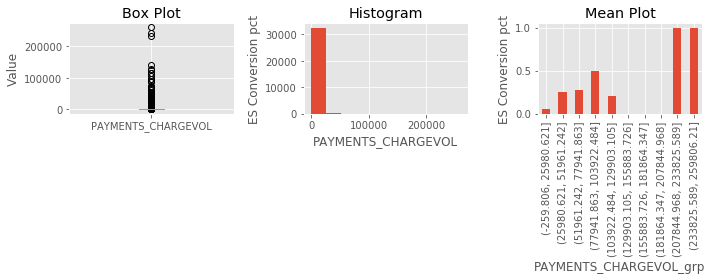

                              mean  count
PAYMENTS_CHARGEVOL_grp                   
(-259.806, 25980.621]     0.050301  32544
(25980.621, 51961.242]    0.250000     40
(51961.242, 77941.863]    0.272727     11
(77941.863, 103922.484]   0.500000      4
(103922.484, 129903.105]  0.200000      5
(129903.105, 155883.726]  0.000000      1
(155883.726, 181864.347]       NaN      0
(181864.347, 207844.968]       NaN      0
(207844.968, 233825.589]  1.000000      1
(233825.589, 259806.21]   1.000000      2
                                                          
                                                          
EDA Analysis for variable: SM_SBG_Tot_Revenue


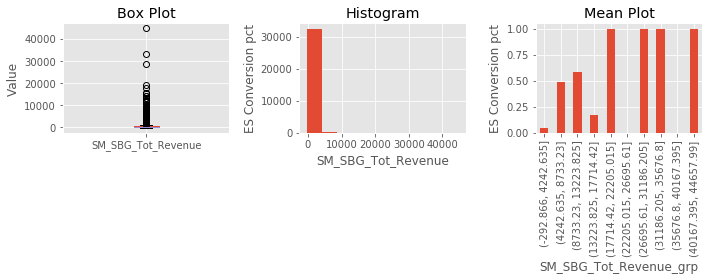

                            mean  count
SM_SBG_Tot_Revenue_grp                 
(-292.866, 4242.635]    0.049348  32504
(4242.635, 8733.23]     0.487805     82
(8733.23, 13223.825]    0.583333     12
(13223.825, 17714.42]   0.166667      6
(17714.42, 22205.015]   1.000000      1
(22205.015, 26695.61]        NaN      0
(26695.61, 31186.205]   1.000000      1
(31186.205, 35676.8]    1.000000      1
(35676.8, 40167.395]         NaN      0
(40167.395, 44657.99]   1.000000      1
                                                          
                                                          
EDA Analysis for variable: QBDT_QTD_REV


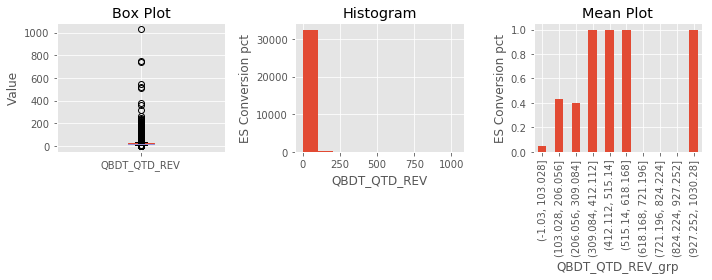

                        mean  count
QBDT_QTD_REV_grp                   
(-1.03, 103.028]    0.049363  32494
(103.028, 206.056]  0.431579     95
(206.056, 309.084]  0.400000     10
(309.084, 412.112]  1.000000      3
(412.112, 515.14]   1.000000      1
(515.14, 618.168]   1.000000      2
(618.168, 721.196]       NaN      0
(721.196, 824.224]  0.000000      2
(824.224, 927.252]       NaN      0
(927.252, 1030.28]  1.000000      1
                                                          
                                                          
EDA Analysis for variable: QBO_REV


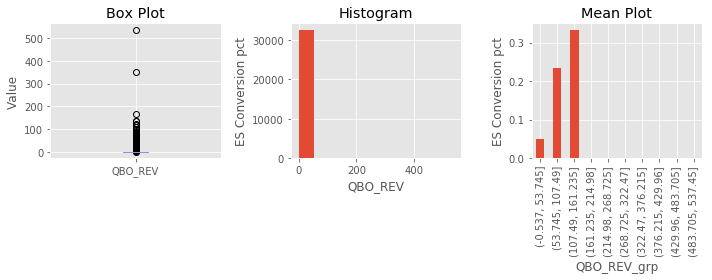

                       mean  count
QBO_REV_grp                       
(-0.537, 53.745]   0.050570  32569
(53.745, 107.49]   0.233333     30
(107.49, 161.235]  0.333333      6
(161.235, 214.98]  0.000000      1
(214.98, 268.725]       NaN      0
(268.725, 322.47]       NaN      0
(322.47, 376.215]  0.000000      1
(376.215, 429.96]       NaN      0
(429.96, 483.705]       NaN      0
(483.705, 537.45]  0.000000      1
                                                          
                                                          
EDA Analysis for variable: payroll_last_emp


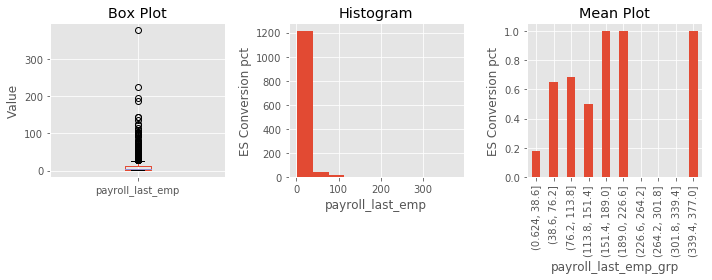

                          mean  count
payroll_last_emp_grp                 
(0.624, 38.6]         0.178454   1216
(38.6, 76.2]          0.650000     40
(76.2, 113.8]         0.687500     16
(113.8, 151.4]        0.500000      6
(151.4, 189.0]        1.000000      1
(189.0, 226.6]        1.000000      2
(226.6, 264.2]             NaN      0
(264.2, 301.8]             NaN      0
(301.8, 339.4]             NaN      0
(339.4, 377.0]        1.000000      1
                                                          
                                                          


In [15]:
def NUM_EDA_graph(variable):
    print('EDA Analysis for variable: {}'.format(variable))
    fig=plt.figure(figsize=(10,4))
    
    ax1=fig.add_subplot(131)
    df[variable].plot.box()
    ax1.set_title('Box Plot')
    ax1.set_ylabel('Value')

    ax2=fig.add_subplot(132)
    df[variable].plot.hist(bins=10)
    ax2.set_xlabel(variable)
    ax2.set_ylabel('ES Conversion pct')
    ax2.set_title('Histogram')
    
    df[variable+'_grp']=pd.cut(df[variable],bins=10)
    ax3=fig.add_subplot(133)
    ax3.set_xlabel(variable+'_grp')
    ax3.set_ylabel('ES Conversion pct')
    df.groupby(df[variable+'_grp']).es_resp.mean().plot.bar()
    ax3.set_title('Mean Plot')
    
#     fig.suptitle('Two Charts')
    plt.tight_layout()
    plt.show()
    
    print(df.groupby(df[variable+'_grp']).es_resp.agg(['mean', 'count']))
    print('                                                          ')
    print('                                                          ')

# NUM_EDA_graph('SM_SBG_Tot_Revenue')    
lst=[
# 'EM_hist_flag',
# 'MRV_Product',
 'PAYMENTS_CHARGEVOL',
# 'PAYMENT_FLAG',
# 'PAYROLL_FLAG',
# 'POE_Product',
# 'PREV_Product',
# 'PREV_channel',
# 'PREV_version',
# 'SM_AttachOffering',
 'SM_SBG_Tot_Revenue',
# 'PA110',
 'QBDT_QTD_REV',
 'QBO_REV',
# 'SU101',
# 'num_yr_last_upgrade',
 'payroll_last_emp',
# 'eager_upgrader',
# 'industry',
# 'prs_flag',
# 'revenue_grp',
# 'supplies_hist_flag',
# 'total_QB_cnt'
]
for i in lst:
    NUM_EDA_graph(i)
#     delete the group variable that's not needed any more
    df.drop(i+'_grp', inplace=True, axis=1)

In [16]:
df.columns

Index([u'cust_id', u'POE_Product', u'POE_version', u'POE_channel',
       u'PREV_Product', u'PREV_version', u'PREV_channel', u'MRV_Product',
       u'MRV_version', u'MRV_channel',
       ...
       u'payroll_last_avgamt', u'es_resp', u'payments_hist_flag', u'hv_flag',
       u'supplies_hist_flag', u'EM_hist_flag', u'prs_flag',
       u'payroll_hist_flag', u'mrv_version_active', u'mod_val_test'],
      dtype='object', length=185)

# Feature Engineering
    - Continuous variable
        - Missing imputation - fill in with mean
        - Capping/Flooring at 1% and 99% percentile for extreme values
        - Math transformations - square, squareroot, log, exp        
    - Categorical variable
        - One hot encoding in some cases
        - Binning meaningful categories together

## Continuous Variables

In [17]:
num_list=['PAYMENTS_CHARGEVOL','SM_SBG_Tot_Revenue','QBDT_QTD_REV','QBO_REV','payroll_last_emp']

In [18]:
# fill in missing, flooring/capping at 1% and 99%
# math transformation - square, square root, log, exp, inverse
def num_feature_engineering (var):
    
    df['R1_'+var]=np.where(df[var].isnull(), df[var].median(), df[var])
    df['R1_'+var]=np.where(df[var] > df[var].quantile(0.99), df[var].quantile(0.99), df['R1_'+var])
    df['R1_'+var]=np.where(df[var] < df[var].quantile(0.01), df[var].quantile(0.01), df['R1_'+var])

    df['R1_'+var+'_sq'] = df['R1_'+var].apply(lambda x: x**2)
    df['R1_'+var+'_sqrt'] = df['R1_'+var].apply(lambda x: x**0.5)
    df['R1_'+var+'_log'] = df['R1_'+var].apply(lambda x: np.log(max(x,0.00001)))
    df['R1_'+var+'_exp']=df['R1_'+var].apply(lambda x: np.exp(min(-x,0)))
    df['R1_'+var+'_inv'] = df['R1_'+var].apply(lambda x: 1/(max(x,0.00001)))
                                             
for i in num_list:
    num_feature_engineering(i)

In [19]:
df.head()

,cust_id,POE_Product,POE_version,POE_channel,PREV_Product,...,R1_payroll_last_emp_sq,R1_payroll_last_emp_sqrt,R1_payroll_last_emp_log,R1_payroll_last_emp_exp,R1_payroll_last_emp_inv
0,159735070,Pro,1997,Mail,Premier,...,25.0,2.236068,1.609438,6.737947e-03,0.200000
1,160105729,Basic,1995,RETAIL,Mac,...,784.0,5.291503,3.332205,6.914400e-13,0.035714
2,163228621,Pro,1999,Web,Pro,...,25.0,2.236068,1.609438,6.737947e-03,0.200000
3,266595274,Basic,1997,Telesales and Emerging,Pro,...,225.0,3.872983,2.708050,3.059023e-07,0.066667
4,276426190,Pro,1997,RETAIL,Pro,...,25.0,2.236068,1.609438,6.737947e-03,0.200000


In [20]:
# df.columns.values

## Categorical Variables one hot encoding

In [21]:
cat_list=['EM_hist_flag','MRV_Product','PAYMENT_FLAG','PAYROLL_FLAG','POE_Product','PREV_Product','PREV_channel', \
'PREV_version','SM_AttachOffering','PA110','SU101','num_yr_last_upgrade','eager_upgrader','industry','prs_flag', \
'revenue_grp','supplies_hist_flag','total_QB_cnt']

In [29]:
# one hot encoding of all categorical variables.  We also encode NaN as a possible predictor, 
# as well as only keeping k-1 values for each variable.
def cat_feature_engineering (var):
    global df
    var_def=pd.get_dummies(df[var], dummy_na = True, drop_first = True, prefix = 'R1_'+var)
    df = pd.merge(df, var_def, left_index=True, right_index=True)
   
    
for i in cat_list:
    cat_feature_engineering(i)



In [38]:
df.shape

(34340, 369)

In [32]:
column_lst=df.columns.values
column_lst

array(['cust_id', 'POE_Product', 'POE_version', 'POE_channel',
       'PREV_Product', 'PREV_version', 'PREV_channel', 'MRV_Product',
       'MRV_version', 'MRV_channel', 'MRV_agg_seats', 'PAYMENT_FLAG',
       'PAYROLL_FLAG', 'num_yr_first_QB', 'num_yr_last_QB',
       'num_yr_last_upgrade', 'total_QB_cnt', 'eager_upgrader',
       'QB_cnt_2009', 'emp_number', 'annual_revenue', 'yrs_in_biz',
       'industry', 'emp_grp', 'revenue_grp', 'yrs_in_biz_grp', 'PA001',
       'PA002', 'PA003', 'PA004', 'PA005', 'PA006', 'PA011', 'PA012',
       'PA013', 'PA014', 'PA015', 'PA016', 'PA021', 'PA022', 'PA023',
       'PA024', 'PA025', 'PA026', 'PA031', 'PA032', 'PA033', 'PA034',
       'PA035', 'PA036', 'PA041', 'PA042', 'PA043', 'PA044', 'PA045',
       'PA046', 'PA051', 'PA052', 'PA053', 'PA054', 'PA055', 'PA056',
       'PA101', 'PA102', 'PA103', 'PA104', 'PA110', 'SM_AttachOffering',
       'QBDT', 'QBDT_REV', 'QBDT_LAG_12MTH_REV', 'QBDT_QTD_REV', 'QBES',
       'QBES_REV', 'QBES_LAG_12MTH_RE

In [37]:
# rename all variables with '_________.0' from the dummy encoding
for i in column_lst:
    if i.endswith('.0'):
#         print('found '+i)
#         print(i[0:-2])
        df.rename(columns = {i: i[0:-2]}, inplace = True)
        
df.columns.values    

found R1_EM_hist_flag_1.0
R1_EM_hist_flag_1
found R1_PAYMENT_FLAG_1.0
R1_PAYMENT_FLAG_1
found R1_PAYROLL_FLAG_1.0
R1_PAYROLL_FLAG_1
found R1_PREV_version_1995.0
R1_PREV_version_1995
found R1_PREV_version_1996.0
R1_PREV_version_1996
found R1_PREV_version_1997.0
R1_PREV_version_1997
found R1_PREV_version_1998.0
R1_PREV_version_1998
found R1_PREV_version_1999.0
R1_PREV_version_1999
found R1_PREV_version_2000.0
R1_PREV_version_2000
found R1_PREV_version_2001.0
R1_PREV_version_2001
found R1_PREV_version_2002.0
R1_PREV_version_2002
found R1_PREV_version_2003.0
R1_PREV_version_2003
found R1_PREV_version_2004.0
R1_PREV_version_2004
found R1_PREV_version_2005.0
R1_PREV_version_2005
found R1_PREV_version_2006.0
R1_PREV_version_2006
found R1_PREV_version_2007.0
R1_PREV_version_2007
found R1_PREV_version_2008.0
R1_PREV_version_2008
found R1_PREV_version_2009.0
R1_PREV_version_2009
found R1_PREV_version_2010.0
R1_PREV_version_2010
found R1_PREV_version_2011.0
R1_PREV_version_2011
found R1_PREV_vers

array(['cust_id', 'POE_Product', 'POE_version', 'POE_channel',
       'PREV_Product', 'PREV_version', 'PREV_channel', 'MRV_Product',
       'MRV_version', 'MRV_channel', 'MRV_agg_seats', 'PAYMENT_FLAG',
       'PAYROLL_FLAG', 'num_yr_first_QB', 'num_yr_last_QB',
       'num_yr_last_upgrade', 'total_QB_cnt', 'eager_upgrader',
       'QB_cnt_2009', 'emp_number', 'annual_revenue', 'yrs_in_biz',
       'industry', 'emp_grp', 'revenue_grp', 'yrs_in_biz_grp', 'PA001',
       'PA002', 'PA003', 'PA004', 'PA005', 'PA006', 'PA011', 'PA012',
       'PA013', 'PA014', 'PA015', 'PA016', 'PA021', 'PA022', 'PA023',
       'PA024', 'PA025', 'PA026', 'PA031', 'PA032', 'PA033', 'PA034',
       'PA035', 'PA036', 'PA041', 'PA042', 'PA043', 'PA044', 'PA045',
       'PA046', 'PA051', 'PA052', 'PA053', 'PA054', 'PA055', 'PA056',
       'PA101', 'PA102', 'PA103', 'PA104', 'PA110', 'SM_AttachOffering',
       'QBDT', 'QBDT_REV', 'QBDT_LAG_12MTH_REV', 'QBDT_QTD_REV', 'QBES',
       'QBES_REV', 'QBES_LAG_12MTH_RE

In [39]:
# ALL transformed/cleaned up variables start with R1_ and will be in the keep_lst.
keep_lst=[]
for i in df.columns.values:
    if i.startswith('R1_'):
        keep_lst.append(i)

print(keep_lst)        

['R1_PAYMENTS_CHARGEVOL', 'R1_PAYMENTS_CHARGEVOL_sq', 'R1_PAYMENTS_CHARGEVOL_sqrt', 'R1_PAYMENTS_CHARGEVOL_log', 'R1_PAYMENTS_CHARGEVOL_exp', 'R1_PAYMENTS_CHARGEVOL_inv', 'R1_SM_SBG_Tot_Revenue', 'R1_SM_SBG_Tot_Revenue_sq', 'R1_SM_SBG_Tot_Revenue_sqrt', 'R1_SM_SBG_Tot_Revenue_log', 'R1_SM_SBG_Tot_Revenue_exp', 'R1_SM_SBG_Tot_Revenue_inv', 'R1_QBDT_QTD_REV', 'R1_QBDT_QTD_REV_sq', 'R1_QBDT_QTD_REV_sqrt', 'R1_QBDT_QTD_REV_log', 'R1_QBDT_QTD_REV_exp', 'R1_QBDT_QTD_REV_inv', 'R1_QBO_REV', 'R1_QBO_REV_sq', 'R1_QBO_REV_sqrt', 'R1_QBO_REV_log', 'R1_QBO_REV_exp', 'R1_QBO_REV_inv', 'R1_payroll_last_emp', 'R1_payroll_last_emp_sq', 'R1_payroll_last_emp_sqrt', 'R1_payroll_last_emp_log', 'R1_payroll_last_emp_exp', 'R1_payroll_last_emp_inv', 'R1_EM_hist_flag_1', 'R1_EM_hist_flag_nan', 'R1_MRV_Product_Premier', 'R1_MRV_Product_Pro', 'R1_MRV_Product_nan', 'R1_PAYMENT_FLAG_1', 'R1_PAYMENT_FLAG_nan', 'R1_PAYROLL_FLAG_1', 'R1_PAYROLL_FLAG_nan', 'R1_POE_Product_Mac', 'R1_POE_Product_Premier', 'R1_POE_Produ

In [41]:
len(keep_lst)

184

# Feature Selection/Modeling

## Lasso to select features

In [45]:
X=df[keep_lst]
y=df.es_resp

In [89]:
cv = 5 # 5-fold CV
c = [1, 10, 10**2, 10**3, 10**4, 10**5, 10**6 ]

gs = model_selection.GridSearchCV(
    estimator = linear_model.LogisticRegression(),
    param_grid = {'C': c, 'penalty': ['l1'] },
    cv = model_selection.KFold(n_splits = cv, shuffle = True, random_state = 12345)
)

gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': [1, 10, 100, 1000, 10000, 100000, 1000000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [91]:
gs.best_score_

0.95366919044845666

In [93]:
gs.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
model_lasso_optimized=linear_model.LogisticRegression(C=1, penalty='l1').fit(X,y)

In [72]:
len(model_lasso_optimized.coef_.T)

184

In [73]:
len(X.columns.values)

184

In [75]:
sorted(zip(abs(model_lasso_optimized.coef_.T), X.columns.values), reverse = True)

[(array([ 2.52516487]), 'R1_PREV_Product_QBES'),
 (array([ 1.9862379]), 'R1_PAYROLL_FLAG_1'),
 (array([ 1.69871682]), 'R1_PA110_8'),
 (array([ 1.50509239]), 'R1_revenue_grp_8. > $5M'),
 (array([ 1.33239089]), 'R1_PA110_6'),
 (array([ 1.20718874]), 'R1_QBO_REV_sqrt'),
 (array([ 1.17195181]), 'R1_SM_AttachOffering_QB + Payroll + Supplies'),
 (array([ 1.02117287]), 'R1_total_QB_cnt_17'),
 (array([ 0.97838534]),
  'R1_SM_AttachOffering_QB + Payments + Payroll + Supplies'),
 (array([ 0.9607108]), 'R1_revenue_grp_6. $1M - 3M'),
 (array([ 0.92944144]), 'R1_revenue_grp_7. $3M - 5M'),
 (array([ 0.82419254]), 'R1_total_QB_cnt_15'),
 (array([ 0.79769506]), 'R1_SM_AttachOffering_QB + Payments + Payroll'),
 (array([ 0.75707542]), 'R1_SM_AttachOffering_nan'),
 (array([ 0.71764776]), 'R1_num_yr_last_upgrade_1'),
 (array([ 0.64587293]), 'R1_SU101_1'),
 (array([ 0.57801223]), 'R1_num_yr_last_upgrade_12'),
 (array([ 0.56923998]), 'R1_SM_AttachOffering_Only QB'),
 (array([ 0.53942898]), 'R1_PREV_version_

## Randomized Logitic Regression to select features

In [95]:
#feature selection using randomized logistic regression
RLR1 = linear_model.RandomizedLogisticRegression(n_resampling = 20)
RLR1.fit(X, y)
RLR1_selected_features = RLR1.get_support()
RLR1_selected_features = X.columns.values[RLR1_selected_features]
RLR1_selected_features


array(['R1_SM_SBG_Tot_Revenue', 'R1_SM_SBG_Tot_Revenue_sq',
       'R1_QBDT_QTD_REV_sq', 'R1_payroll_last_emp',
       'R1_payroll_last_emp_sqrt', 'R1_payroll_last_emp_log',
       'R1_MRV_Product_Premier', 'R1_PAYROLL_FLAG_1',
       'R1_POE_Product_Premier', 'R1_PREV_Product_Premier',
       'R1_PREV_Product_QBES', 'R1_PA110_nan', 'R1_num_yr_last_upgrade_1',
       'R1_industry_nan', 'R1_prs_flag_1', 'R1_revenue_grp_6. $1M - 3M',
       'R1_revenue_grp_7. $3M - 5M', 'R1_revenue_grp_8. > $5M',
       'R1_revenue_grp_nan'], dtype=object)

### There are a lot of features that overalap between the lasso technique and randomized logistic regression
       - 'R1_SM_SBG_Tot_Revenue'
       - 'R1_revenue_grp_8. > $5M'
       - 'R1_PREV_Product_QBES'
       - etc

In [116]:
LR1 = linear_model.LogisticRegression(penalty = 'l1', C=10**2)
LR1.fit(X[RLR1_selected_features],y)
preds = LR1.predict(X[RLR1_selected_features])
confusion_matrix(y, preds)


array([[32508,   115],
       [ 1465,   252]])

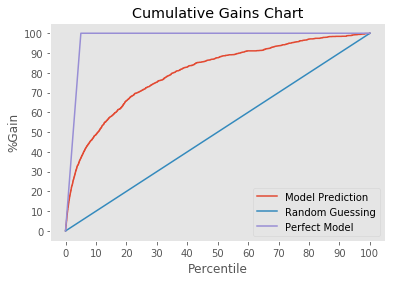

In [136]:
LR1_PREDICTED_PROB = [i[1] for i in LR1.predict_proba(X.loc[:, RLR1_selected_features])]
cum_gain_chart(LR1_PREDICTED_PROB, y, return_df = False)

In [145]:
# function to create bin labels for equal sized groups
# N is the total number of rows, n_groups is the number of groups to create
def bin_index(N, n_groups):
    remainder = N % n_groups
    group_size = int(N/n_groups)
    
    group_index = []
    for i in range(0,remainder):
        group_index.append([i+1] * (group_size + 1))
    for i in range(remainder, n_groups):
        group_index.append([i+1] * group_size)
        
    return [item for sublist in group_index for item in sublist]

# function to add auto-aligned labels to vertical bar char
def autolabel(rects, ax):
    # get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    for rect in rects:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)
        
        ax.text(rect.get_x() + rect.get_width()/2., label_position, '%.2f' % round(height, 2), 
                ha = 'center', va = 'bottom')

# plots lift chart
def lift_chart(predicted_prob, actual ,n_deciles = 10):
    propensity_df = pd.DataFrame({'propensity': predicted_prob, 'lift': actual})
    propensity_df.sort_values(by = ['propensity'], axis = 0, ascending = True, inplace = True)
    propensity_df.index = bin_index(len(propensity_df), n_deciles)
    propensity_df.drop('propensity', axis = 1, inplace = True)
    groups_df = propensity_df.groupby(propensity_df.index).mean() / propensity_df.mean()
    ax = groups_df.plot(kind = 'bar', figsize = (n_deciles/2, 5), legend = True)
    ax.set_xlabel("Deciles")
    ax.set_ylabel("Decile Mean / Global Mean")
    ax.set_title("Lift by Decile")
    
    autolabel(ax.patches, ax)
    
    return ax


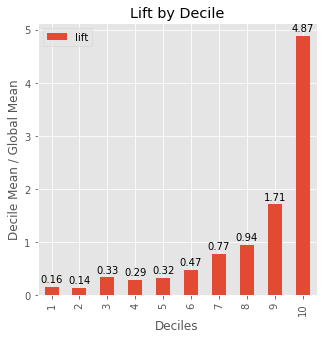

In [147]:
lift_chart(LR1_PREDICTED_PROB, y ,10)

In [184]:
accuracy_score(y,LR1.predict(X))

0.95465928945835765

## Random Forest 

In [79]:
cv = 5 # 5-fold CV
max_features=[2,3,4,5,6]
min_samples_leaf = [5,10,15,20,25,30]
oob_score = [True, False]

gs1 = model_selection.GridSearchCV(
    estimator = ensemble.RandomForestClassifier(),
    param_grid = {'max_features': max_features, 
                  'min_samples_leaf': min_samples_leaf,
                  'oob_score': oob_score},
    cv = model_selection.KFold(n_splits = cv, shuffle = True, random_state = 12345)
)

gs1.fit(X, y)

C:\Users\jmiller16\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\jmiller16\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


GridSearchCV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [2, 3, 4, 5, 6], 'oob_score': [True, False], 'min_samples_leaf': [5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [80]:
gs1.cv_results_

{'mean_fit_time': array([ 0.32839999,  0.19720001,  0.28439999,  0.20020003,  0.26879992,
         0.14059997,  0.26620002,  0.22779999,  0.25320001,  0.16560001,
         0.26580005,  0.12480001,  0.32779999,  0.24099998,  0.45839996,
         0.27620001,  0.27839999,  0.21560011,  0.35279999,  0.2       ,
         0.27159996,  0.15599999,  0.29060001,  0.19440002,  0.41580005,
         0.27379999,  0.29699998,  0.26880002,  0.37259998,  0.26260009,
         0.3494    ,  0.20620003,  0.36259999,  0.21960006,  0.46900001,
         0.34680004,  0.71439996,  0.3908    ,  0.36259999,  0.28740005,
         0.42480006,  0.34960003,  0.32219996,  0.33439999,  0.40200005,
         0.29679995,  0.37499995,  0.25940003,  0.52620001,  0.37199998,
         0.37520003,  0.33439994,  0.43579998,  0.32280002,  0.37940001,
         0.34380002,  0.4092    ,  0.30319986,  0.38460007,  0.29080009]),
 'mean_score_time': array([ 0.03100004,  0.03099995,  0.03119998,  0.03439999,  0.0250001 ,
         0.01

In [81]:
gs1.best_score_

0.95302853814793242

In [83]:
gs1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [152]:
# Best RF model
# question: should I use a subset of all the features?
model_rf=ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False).fit(X,y)

In [88]:
# feature importance in descending order from the RF model
sorted(zip(model_rf.feature_importances_, X.columns.values), reverse = True)

[(0.069052655545785324, 'R1_SM_SBG_Tot_Revenue'),
 (0.064938631752581993, 'R1_SM_SBG_Tot_Revenue_sq'),
 (0.060781627180553778, 'R1_SM_SBG_Tot_Revenue_sqrt'),
 (0.04973990832894791, 'R1_PREV_Product_QBES'),
 (0.044865115187247936, 'R1_QBDT_QTD_REV_log'),
 (0.038612294755537381, 'R1_SM_SBG_Tot_Revenue_inv'),
 (0.035425361227180395, 'R1_SM_SBG_Tot_Revenue_log'),
 (0.034411876880822638, 'R1_PAYROLL_FLAG_1'),
 (0.032779177123470282, 'R1_payroll_last_emp_log'),
 (0.032570952420994392, 'R1_QBDT_QTD_REV_sq'),
 (0.031876959832447718, 'R1_payroll_last_emp'),
 (0.027879686346767341, 'R1_QBDT_QTD_REV_sqrt'),
 (0.026898858242033585, 'R1_payroll_last_emp_inv'),
 (0.022082614431547857, 'R1_QBDT_QTD_REV'),
 (0.019760781488575751, 'R1_payroll_last_emp_sq'),
 (0.019601489820494304, 'R1_QBDT_QTD_REV_inv'),
 (0.01885296017384417, 'R1_payroll_last_emp_sqrt'),
 (0.017907355743557792, 'R1_payroll_last_emp_exp'),
 (0.01764592883142984, 'R1_PREV_channel_Unknown'),
 (0.014978697784107212, 'R1_revenue_grp_6. $1M

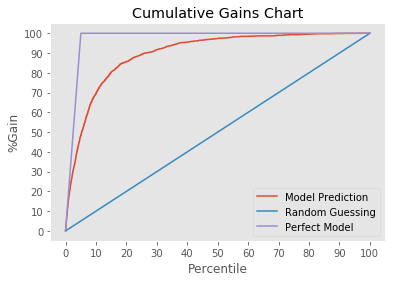

In [151]:
model_rf_PREDICTED_PROB = [i[1] for i in model_rf.predict_proba(X)]
cum_gain_chart(model_rf_PREDICTED_PROB, y, return_df = False)

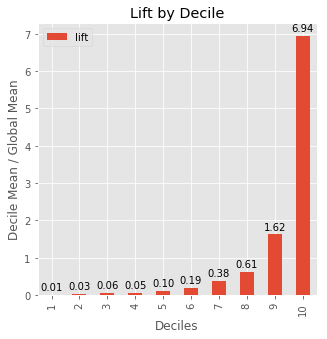

In [150]:
lift_chart(model_rf_PREDICTED_PROB, y ,10)

In [183]:
accuracy_score(y,model_rf.predict(X))

0.95529994175888178

# Gradiant Boosted Tree

In [153]:
# Now Build Gradient Boosting Model
# perform grid search for hyper parameter tuning
parameters = {'loss': ['deviance', 'exponential'], 'max_depth' : [ 3, 4, 5], 'max_features':[None, 'auto']}
GBC1 = GradientBoostingClassifier(n_estimators = 200)
GBC_GRID1 = GridSearchCV(GBC1, parameters, scoring = "roc_auc", verbose = 3)
GBC_GRID1.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_features=None, loss=deviance, max_depth=3 ...................
[CV]  max_features=None, loss=deviance, max_depth=3, score=0.797983, total=  17.3s
[CV] max_features=None, loss=deviance, max_depth=3 ...................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


[CV]  max_features=None, loss=deviance, max_depth=3, score=0.744675, total=  20.7s
[CV] max_features=None, loss=deviance, max_depth=3 ...................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.5s remaining:    0.0s


[CV]  max_features=None, loss=deviance, max_depth=3, score=0.859664, total=  20.2s
[CV] max_features=auto, loss=deviance, max_depth=3 ...................
[CV]  max_features=auto, loss=deviance, max_depth=3, score=0.798589, total=  17.6s
[CV] max_features=auto, loss=deviance, max_depth=3 ...................
[CV]  max_features=auto, loss=deviance, max_depth=3, score=0.745137, total=  21.4s
[CV] max_features=auto, loss=deviance, max_depth=3 ...................
[CV]  max_features=auto, loss=deviance, max_depth=3, score=0.863584, total=  21.5s
[CV] max_features=None, loss=deviance, max_depth=4 ...................
[CV]  max_features=None, loss=deviance, max_depth=4, score=0.791017, total=  26.2s
[CV] max_features=None, loss=deviance, max_depth=4 ...................
[CV]  max_features=None, loss=deviance, max_depth=4, score=0.737089, total=  28.1s
[CV] max_features=None, loss=deviance, max_depth=4 ...................
[CV]  max_features=None, loss=deviance, max_depth=4, score=0.852797, total= 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 18.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'auto'], 'loss': ['deviance', 'exponential'], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=3)

In [154]:
GBC_GRID1.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [155]:
GBC1 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False).fit(X,y)

In [160]:
# feature importance in descending order from the GBC model
sorted(zip(GBC1.feature_importances_, X.columns.values), reverse = True)


[(0.07785875669645341, 'R1_SM_SBG_Tot_Revenue_inv'),
 (0.041648115900908389, 'R1_PAYROLL_FLAG_1'),
 (0.031846971771812109, 'R1_QBDT_QTD_REV_inv'),
 (0.029117954003629022, 'R1_SM_SBG_Tot_Revenue_sqrt'),
 (0.028231618967207852, 'R1_SM_SBG_Tot_Revenue_sq'),
 (0.025427939602444629, 'R1_SM_AttachOffering_Only QB'),
 (0.024177456579794348, 'R1_SM_SBG_Tot_Revenue'),
 (0.023862806077611019, 'R1_SM_SBG_Tot_Revenue_log'),
 (0.017429076094925545, 'R1_total_QB_cnt_8'),
 (0.014293297915466342, 'R1_payroll_last_emp_inv'),
 (0.014227646987724241, 'R1_QBDT_QTD_REV_sqrt'),
 (0.013709643667212956, 'R1_industry_nan'),
 (0.01322906918045893, 'R1_PREV_Product_QBES'),
 (0.012884983326868656, 'R1_PAYMENTS_CHARGEVOL_inv'),
 (0.012099772878100828, 'R1_revenue_grp_6. $1M - 3M'),
 (0.011398519745745577, 'R1_industry_Wholesale Trade'),
 (0.011034842331370209, 'R1_SM_AttachOffering_QB + Payments + Payroll'),
 (0.010598202957815423, 'R1_revenue_grp_8. > $5M'),
 (0.010530343972247773, 'R1_total_QB_cnt_2'),
 (0.01046

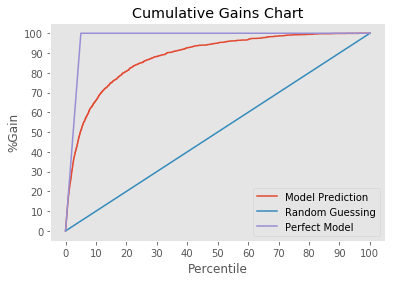

In [161]:
model_GBC_PREDICTED_PROB = [i[1] for i in GBC1.predict_proba(X)]
cum_gain_chart(model_GBC_PREDICTED_PROB, y, return_df = False)

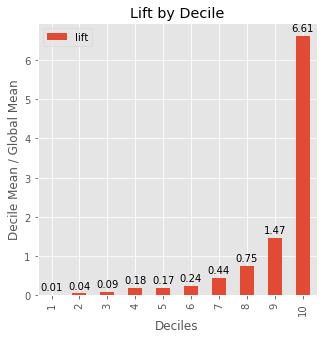

In [162]:
lift_chart(model_GBC_PREDICTED_PROB, y ,10)

In [185]:
accuracy_score(y,GBC1.predict(X))

0.95885264997087949

### it doesn't make sense to use accuracy/precision/recall to measure model performance.  Having a cutoff at 0.5 is way too stringent.  We do not need to have 80% precision score.  We want to be able to target as few people as possible while able to reach over 80% of recall.

In [187]:
precision_score(y,GBC1.predict(X))

0.80645161290322576

In [188]:
recall_score(y,GBC1.predict(X))

0.23296447291788003

# Can I combine all of the model scores together and get something better?

In [163]:
from sklearn.ensemble import  VotingClassifier 

In [172]:
log_clf=LR1
rnd_clf=model_rf
gbc_clf=GBC1

voting_clf=VotingClassifier(
    estimators=[('lr', log_clf),('rf',rnd_clf),('gbc',gbc_clf)],
    voting='soft')
voting_clf.fit(X,y)


VotingClassifier(estimators=[('lr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...=500, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

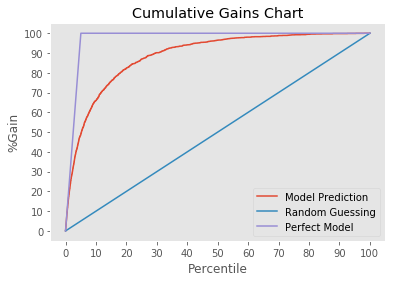

In [176]:
model_clf_PREDICTED_PROB = [i[1] for i in voting_clf.predict_proba(X)]
cum_gain_chart(model_clf_PREDICTED_PROB, y, return_df = False)

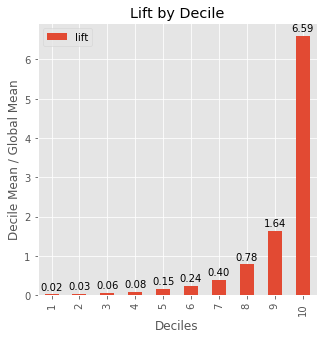

In [177]:
lift_chart(model_clf_PREDICTED_PROB, y ,10)

In [186]:
accuracy_score(y,voting_clf.predict(X))

0.95713453698311013

# It's not done!

- So far preliminary models are showing RF to be a much better fit than Logistic.  Top decile index is almost at 7, which is significantly higher than the current Logistic we have in production at 5.2.  Will need to score on the test dataset and see if there are any problems.
- each of the models need to be further tuned.  I know the Logistic is not as good as it can be.
- binning similar values together for the categorical variables is a next step
- Are there other methods to try as well, such as SVM, NB, Deep Learning?
- a better blending/voting system 